In [4]:
import pyarrow.orc as orc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



reader = orc.ORCFile('merchants_recommendation_final.orc')

# Read only the first stripe (contains a few hundred thousand rows)
# This stays well within your RAM limits
sample_table = reader.read_stripe(0)
sample_table=sample_table.to_pandas()
sample_table.info()
sample_table.head()





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824320 entries, 0 to 824319
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                824320 non-null  int32         
 1   card_id                824320 non-null  int32         
 2   amount                 824320 non-null  object        
 3   merchant_name          824320 non-null  object        
 4   merchant_city          824320 non-null  object        
 5   merchant_state         677481 non-null  object        
 6   mcc                    824320 non-null  int32         
 7   transaction_timestamp  824320 non-null  datetime64[ns]
 8   year                   824320 non-null  int32         
 9   month                  824320 non-null  int32         
 10  person_name            824320 non-null  object        
 11  current_age            824320 non-null  int64         
 12  gender                 824320 non-null  obje

,user_id,card_id,amount,merchant_name,merchant_city,merchant_state,mcc,transaction_timestamp,year,month,...,zipcode,card_brand,card_type,credit_limit,transaction_id,is_weekend,day_part,utilization_rate,is_local,merchant_zip
0,45,0,225.09,7563745130987953360,Maryland Heights,MO,8021,2020-02-01 16:18:00,2020,2,...,63043,Mastercard,Credit,18100.00,45-0-1580554080,True,Afternoon,0.0124359116022,True,63043
1,45,0,39.92,-245178307025547046,Bridgeton,MO,5311,2020-02-03 01:13:00,2020,2,...,63043,Mastercard,Credit,18100.00,45-0-1580672580,False,Night,0.0022055248619,False,63044
2,45,0,111.05,-4693979874497918566,Maryland Heights,MO,7538,2020-02-03 08:58:00,2020,2,...,63043,Mastercard,Credit,18100.00,45-0-1580700480,False,Morning,0.0061353591160,True,63043
3,45,0,15.17,4722913068560264812,Herculaneum,MO,5411,2020-02-03 10:39:00,2020,2,...,63043,Mastercard,Credit,18100.00,45-0-1580706540,False,Morning,0.0008381215470,False,63048
4,45,0,7.72,2923801370956434558,Maryland Heights,MO,5411,2020-02-04 08:22:00,2020,2,...,63043,Mastercard,Credit,18100.00,45-0-1580784720,False,Morning,0.0004265193370,True,63043


In [ ]:
import pandas as pd

df_list = []

# Loop through every stripe and take 5% of the data
for i in range(reader.nstripes):
    stripe_df = reader.read_stripe(i).to_pandas()
    sample_chunk = stripe_df.sample(frac=0.05) # Take 5% of this chunk
    df_list.append(sample_chunk)
    
    del stripe_df # Free memory immediately

# Combining into one final sampled DataFrame
df_final_sample = pd.concat(df_list)
df_sample_final['amount_numeric'] = df_sample_final['amount'].replace('[\$,]', '', regex=True).astype(float)

## Statistics of the transaction details

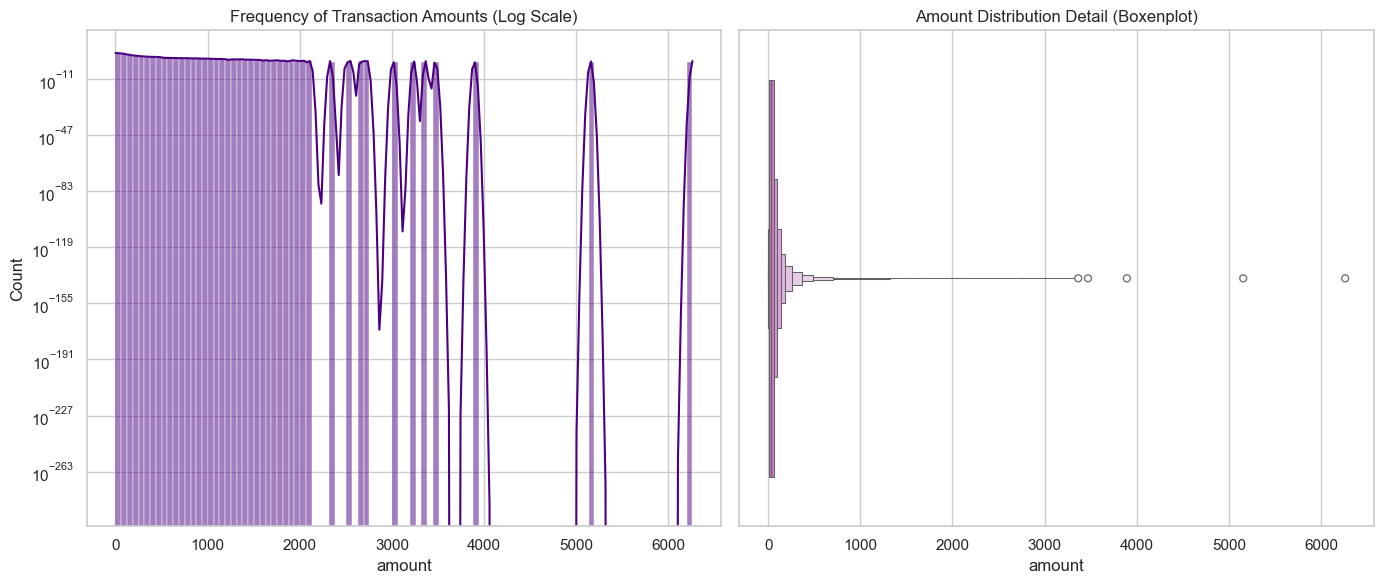

In [6]:

sns.set_theme(style="whitegrid")

plt.figure(figsize=(14, 6))

# Plot 1: The distribution with a Log scale
plt.subplot(1, 2, 1)
sns.histplot(df_final_sample['amount'], bins=100, kde=True, color="indigo")
plt.yscale('log')
plt.title("Frequency of Transaction Amounts (Log Scale)")

# Plot 2: Boxenplot for outlier visibility
plt.subplot(1, 2, 2)
sns.boxenplot(x=df_final_sample['amount'], color="orchid")
plt.title("Amount Distribution Detail (Boxenplot)")

plt.tight_layout()
plt.show()

    Mass Volume: Most transactions are small, daily purchases (groceries, coffee, gas).
    High-Value Outliers: The small spikes you see near $2,500–$3,000 represent "big-ticket" items like electronics, furniture, or travel bookings.
    And very high amount are acting as outliers here

## Category analysis

C:\Users\ritik\AppData\Local\Temp\ipykernel_20744\105661569.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_top_cats, y='merchant_name', order=top_cats, palette="viridis")


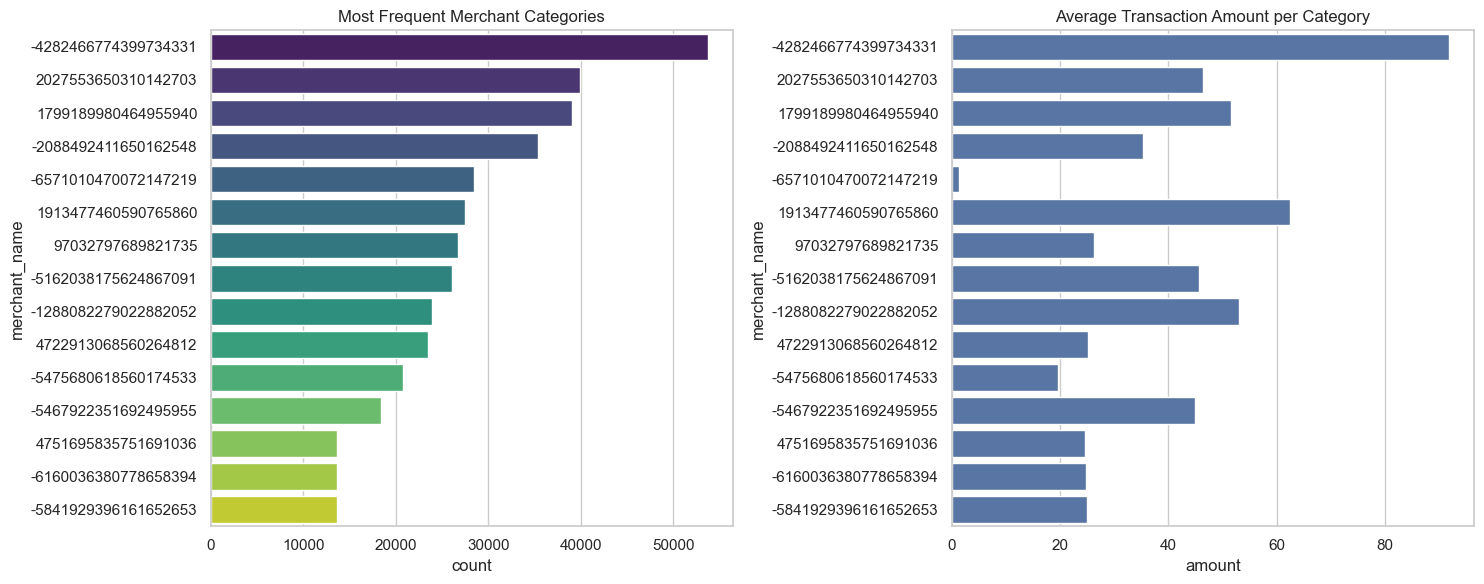

In [11]:
plt.figure(figsize=(15, 6))

# Get top 15 categories by transaction volume
top_cats = df_final_sample['merchant_name'].value_counts().nlargest(15).index
df_top_cats = df_final_sample[df_final_sample['merchant_name'].isin(top_cats)]

# Plot 1: Volume per Category
plt.subplot(1, 2, 1)
sns.countplot(data=df_top_cats, y='merchant_name', order=top_cats, palette="viridis")
plt.title("Most Frequent Merchant Categories")

# Plot 2: Average Spend per Category
plt.subplot(1, 2, 2)
sns.barplot(data=df_top_cats, x='amount', y='merchant_name', order=top_cats, estimator='mean', errorbar=None)
plt.title("Average Transaction Amount per Category")

plt.tight_layout()
plt.show()

## Is there any correlation among the columns?

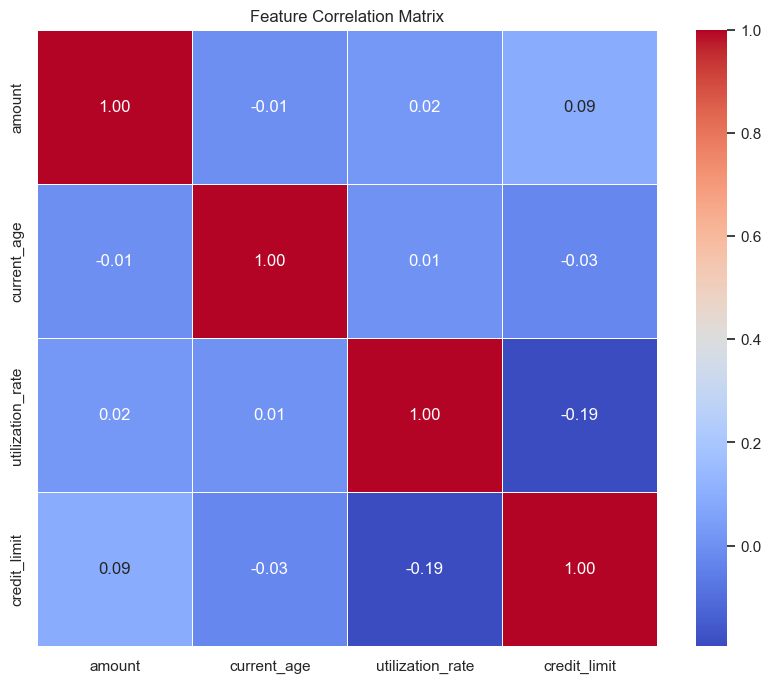

In [17]:
plt.figure(figsize=(10, 8))
df_final_sample['amount'] = df_final_sample['amount'].replace('[\$,]', '', regex=True).astype(float)
df_final_sample['credit_limit'] = df_final_sample['credit_limit'].replace('[\$,]', '', regex=True).astype(float)
df_final_sample['utilization_rate'] = df_final_sample['utilization_rate'].replace('[\%,]', '', regex=True).astype(float)

# Select numerical columns only
num_cols = ['amount', 'current_age', 'utilization_rate', 'credit_limit']
corr = df_final_sample[num_cols].corr()

# Create a heatmap with Seaborn
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

**Interpretation:**
    It is clearly visible there is almost no linear correlation between your numerical features. Most values are near 0.00, indicating that these variables move independently of one another.

C:\Users\ritik\AppData\Local\Temp\ipykernel_20744\1347241338.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mcc_diversity.index, y=mcc_diversity.values, palette='viridis')


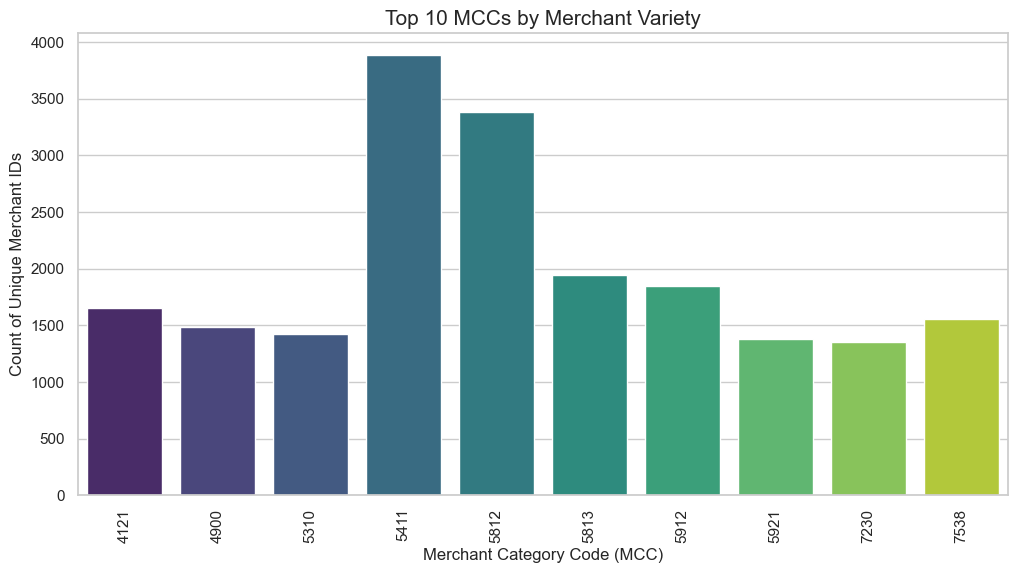

In [20]:
# 1. Group by MCC and find how many unique merchants are in each
mcc_diversity = df_final_sample.groupby('mcc')['merchant_name'].nunique().sort_values(ascending=False).head(10)

# 2. Plotting the results
plt.figure(figsize=(12, 6))
sns.barplot(x=mcc_diversity.index, y=mcc_diversity.values, palette='viridis')

plt.title('Top 10 MCCs by Merchant Variety', fontsize=15)
plt.xlabel('Merchant Category Code (MCC)', fontsize=12)
plt.ylabel('Count of Unique Merchant IDs', fontsize=12)
plt.xticks(rotation=90)
plt.show()

**The bar chart reveals that the dataset is dominated by four high-diversity categories, which represent the most competitive areas for merchant recommendation**:

1. **MCC 5411** (Grocery Stores & Supermarkets): This category has the highest variety (~3,800 merchants). It indicates a highly fragmented market where users have numerous choices for their daily essentials.

2. **MCC 5812** (Eating Places & Restaurants): Following closely, this category shows intense variety (~3,400 merchants). Recommendations in this space are highly valuable for "discovery-based" user experiences.

3. **MCC 5813** (Drinking Places/Bars): Shows significant diversity, representing nightlife and entertainment venues.

4. **MCC 4121** (Taxicabs & Limousines): Despite being a service-oriented category, it maintains a high unique merchant count (~1,600), suggesting a large number of independent operators or localized services.

**Specialized Retail & Services**
Other notable categories with moderate variety include:

1. **Retail & Discounting**: MCC 5310 (Discount Stores) and MCC 5912 (Drug Stores/Pharmacies) show healthy competition, indicating these are frequent stop-points for consumers with several brand options.

2. **Professional Services**: MCC 7230 (Barber & Beauty Shops) and MCC 7538 (Auto Repair Shops) appear in the top 10, highlighting that personalized, high-trust services are a major part of the merchant ecosystem.

3. **Utilities**: MCC 4900 (Electric, Gas, Water) surprisingly shows variety (~1,500), which may indicate a dataset covering multiple geographic regions with different localized utility providers.

**Strategic Implications for Recommendations**
1. **High-Impact Targets**: Recommendations should prioritize MCC 5411 and MCC 5812. Because users face the most "choice fatigue" here, a personalized suggestion for a new grocery store or restaurant adds the most utility.

2. **Brand Loyalty vs. Discovery**: For categories like MCC 4900 (Utilities), the recommendation engine should focus on retention and payment reminders rather than discovery, as these are typically fixed-contract services.

3. **Market Context**: The presence of localized service categories (Auto Repair, Beauty Shops) suggests that geographic features (merchant_city, merchant_zip) will be primary drivers for recommendation accuracy in these specific MCCs.

In [21]:
df_final_sample.mcc.unique()

array([4121, 5541, 5812, 5499, 5912, 5411, 4814, 4111, 9402, 7542, 4829,
       4900, 7538, 5970, 4722, 7230, 5921, 5300, 5310, 5211, 4784, 5942,
       5814, 7349, 5815, 5311, 7832, 7210, 3387, 7922, 5813, 5533, 3596,
       7996, 4214, 7995, 5651, 5719, 5251, 8049, 7011, 3775, 6300, 7802,
       8021, 3640, 5261, 3771, 3058, 8011, 3504, 3359, 3000, 3390, 4899,
       5193, 8099, 5661, 5621, 8111, 7801, 5655, 3730, 7393, 3389, 8931,
       3509, 3405, 5816, 5192, 3684, 8043, 3722, 3001, 5977, 5732, 4131,
       5941, 3780, 3393, 5045, 3132, 8041, 5932, 3066, 3256, 5712, 8062,
       3007, 3260, 4112, 3174, 3395, 1711, 4511, 5094, 7531, 5947, 7549,
       7276, 3006, 3008, 3075, 3005, 5722, 4411, 3144, 3009, 5733],
      dtype=int32)

In [38]:
mcc_map = {
    # Transportation & Travel
    4111: 'Commuter Transport (Trains/Ferries)', 4112: 'Passenger Railways', 
    4121: 'Taxi/Limo/Rideshare', 4131: 'Bus Lines', 4411: 'Cruise Lines', 
    4511: 'Airlines', 4722: 'Travel Agencies', 4784: 'Tolls/Bridge Fees',
    3000: 'United Airlines', 3001: 'American Airlines', 3005: 'British Airways',
    3006: 'Japan Air Lines', 3007: 'Air France', 3008: 'Lufthansa', 
    3009: 'Air Canada', 3058: 'Delta', 3066: 'Southwest', 3075: 'Singapore Airlines',
    3359: 'Payless Car Rental', 3387: 'Alamo Car Rental', 3389: 'Avis Car Rental',
    3390: 'Dollar Rent-A-Car', 3393: 'National Car Rental', 3395: 'Thrifty Car Rental',
    3504: 'Hilton Hotels', 3509: 'Marriott Hotels', 3596: 'Cook Islands Hotels',
    3640: 'Hyatt Hotels', 3684: 'Budget Host Inns', 3722: 'Wyndham Hotels',
    3730: 'MGM Grand Hotel', 3771: 'Caesars Palace', 3775: 'Sands Resort', 3780: 'Disney Hotels',

    # Food & Drink
    5411: 'Grocery Stores/Supermarkets', 5499: 'Misc Food Stores (Convenience)',
    5812: 'Restaurants/Eating Places', 5813: 'Bars/Taverns/Nightclubs',
    5814: 'Fast Food Restaurants', 5815: 'Digital Goods: Media/Books/Movies/Music',
    5816: 'Digital Goods: Games', 5921: 'Package Stores (Beer/Wine/Liquor)',

    # Retail & Shopping
    5211: 'Lumber/Building Materials', 5251: 'Hardware Stores', 
    5261: 'Lawn & Garden Supplies', 5300: 'Wholesale Clubs',
    5310: 'Discount Stores', 5311: 'Department Stores',
    5621: 'Womens Ready-to-Wear Stores', 5651: 'Family Clothing Stores',
    5655: 'Sports Apparel', 5661: 'Shoe Stores', 
    5712: 'Furniture Stores', 5719: 'Home Furnishing Specialty',
    5722: 'Household Appliance Stores', 5732: 'Electronics Stores',
    5733: 'Music Stores/Pianos', 5912: 'Drug Stores/Pharmacies',
    5932: 'Antique/Used Stores', 5941: 'Sporting Goods Stores',
    5942: 'Book Stores', 5947: 'Gift/Souvenir Shops',
    5970: 'Artistic Services', 5977: 'Cosmetic Stores',

    # Utilities & Professional Services
    4814: 'Telecommunication Services', 4829: 'Money Orders/Wire Transfer',
    4899: 'Cable/Pay TV Services', 4900: 'Utilities (Electric/Gas/Water)',
    7210: 'Laundry/Cleaning/Garment Services', 7230: 'Beauty/Barber Shops',
    7276: 'Tax Preparation Services', 7349: 'Cleaning/Maintenance',
    7393: 'Detective/Security Services', 7531: 'Auto Body Repair',
    7538: 'Auto Repair Shops', 7542: 'Car Washes', 
    7549: 'Towing Services', 8111: 'Legal Services', 8931: 'Accounting/Auditing',
    1711: 'Air Conditioning/Heating/Plumbing Contractors',

    # Health & Government
    8011: 'Doctors/Physicians', 8021: 'Dentists/Orthodontists',
    8041: 'Chiropractors', 8043: 'Opticians/Eyeglasses',
    8049: 'Podiatrists/Chiropodists', 8062: 'Hospitals', 
    8099: 'Medical Services (Misc)', 9402: 'Postal Services',

    # Entertainment & Misc
    7801: 'Internet Gambling', 7802: 'Government Licensed Horse/Dog Racing',
    7832: 'Motion Picture Theaters', 7922: 'Theatrical Producers/Ticket Agencies',
    7995: 'Betting/Casino Gambling', 7996: 'Amusement Parks/Carnivals',
    6300: 'Insurance Sales/Underwriting',

    # Industrial/Niche
    3132: 'Hotel (Specific)', 3144: 'Hotel (Specific)', 3174: 'Hotel (Specific)',
    3256: 'Hotel (Specific)', 3260: 'Hotel (Specific)', 3405: 'Hotel (Specific)',
    5045: 'Computers/Software', 5094: 'Precious Stones/Metals/Jewelry',
    5192: 'Books/Periodicals/Newspapers', 5193: 'Florist Supplies'
}
df_final_sample['mcc_description'] = df_final_sample['mcc'].map(mcc_map).fillna('Other Services')


In [28]:
### Temporal Spending patterns

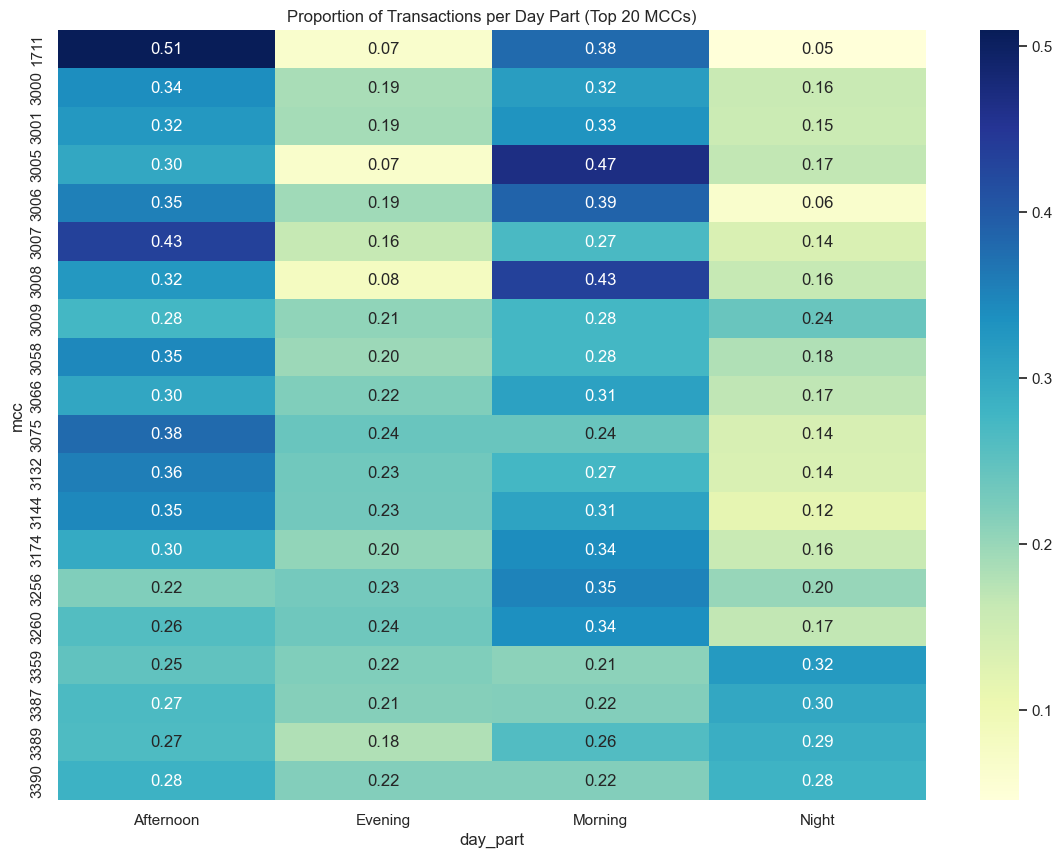

In [29]:
# Create a pivot table for Heatmap: MCC vs Day Part
temporal_counts = df_final_sample.groupby(['mcc', 'day_part']).size().unstack(fill_value=0)

# Normalize by row to see the % distribution of each category across the day
temporal_norm = temporal_counts.div(temporal_counts.sum(axis=1), axis=0)

plt.figure(figsize=(14, 10))
sns.heatmap(temporal_norm.head(20), annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Proportion of Transactions per Day Part (Top 20 MCCs)")
plt.show()


1. **Several MCCs show strong morning concentration (darkest blues in the Morning column):**

    Some MCCs have ~40–50% of transactions in the morning.
    These categories are highly routine-driven

**Interpretation:**
 Likely commute, daily-necessity, or habit-based categoriesUsers interact with these merchants as part of a fixed daily rhythm

**Recommendation implication:**
Morning-time context is a strong signal.Push reminders, quick-access options, or “default” merchants early in the day

2. **Afternoon-heavy but balanced categories:**
Many MCCs peak in the Afternoon (≈30–38%) while still showing meaningful activity elsewhere.

**Interpretation**

    Represents:Errands, Workday spending, Flexible consumption

    These are opportunistic categories, not rigidly time-bound

**Recommendation implication:**
Afternoon is a good window for discovery.
Ranking should emphasize: Proximity,Recency,Variety.

3. **Evening as a secondary peak**

Evening proportions are generally moderate (≈18–25%), rarely dominant.

**Interpretation:**
Evening activity exists but is not the primary driver for most MCCs

**Suggests:**
Wind-down spending.
Planned rather than impulsive usage

**Recommendation implication**
Evening works best for:
Reinforcement, favorites

Context-aware nudges rather than exploration

4. **Night-focused MCCs stand out clearly**

A small number of MCCs show high night activity (≈28–32%), which is unusually strong.

Interpretation

**These categories are:**

Lifestyle- or entertainment-driven

Used late by design, not by chance

Night is a defining behavioral feature, not noise

**Recommendation implication:** Time-of-day should act as a hard filter

Nighttime boosts here will significantly improve relevance

Notice that:
**No MCC is uniformly distributed across the day.**
Every category has a temporal signature

**This means:**
day_part is a high-value feature

MCC × time interactions are non-linear and informative
A single global time weighting would underperform


This heatmap shows when different merchants are relevant.

Significance: Notice the high density (0.51) in the Afternoon for certain codes (top row) and high density in Morning (0.47) for others.

Recommendation Signal: Model should change its "Top 10" list based on the time of day.
-

Morning: Prioritize MCCs with high morning density (e.g., Coffee/Breakfast).

Afternoon: Prioritize MCCs with 0.51 density (e.g., Retail/Services).

In [30]:
df_final_sample['is_local'].head

84415     False
729071     True
635780    False
406000    False
456669     True
Name: is_local, dtype: bool

### Defining the "Local" vs. "Travel" Profile

C:\Users\ritik\AppData\Local\Temp\ipykernel_20744\4146203029.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=geo_summary, x='is_local', y='total_spend', palette='Set2')


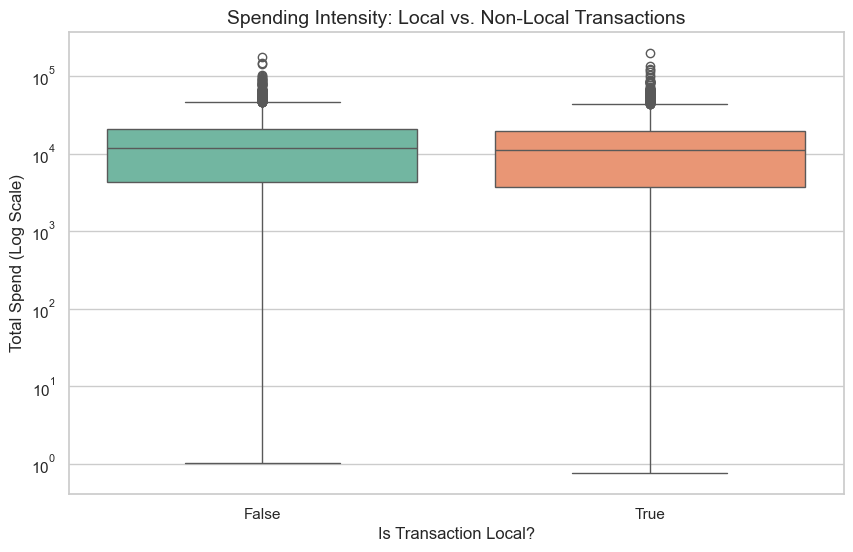

In [39]:
df_final_sample['amount_numeric'] = df_final_sample['amount'].replace('[\$,]', '', regex=True).astype(float)

# We use 'is_local' to split the data and 'mcc_description' for the top category
geo_summary = df_final_sample.groupby(['user_id', 'is_local']).agg(
    total_spend=('amount_numeric', 'sum'),
    avg_ticket=('amount_numeric', 'mean'),
    top_mcc=('mcc_description', lambda x: x.mode()[0] if not x.mode().empty else 'Other')
).reset_index()

# 3. Plotting the results
plt.figure(figsize=(10, 6))

# Boxplot comparing spending intensity
sns.boxplot(data=geo_summary, x='is_local', y='total_spend', palette='Set2')

plt.title('Spending Intensity: Local vs. Non-Local Transactions', fontsize=14)
plt.xlabel('Is Transaction Local?', fontsize=12)
plt.ylabel('Total Spend (Log Scale)', fontsize=12)
plt.yscale('log') # Log scale helps if some users spend significantly more than others
plt.show()

1. **Spending levels are remarkably similar:-**

The medians for local and non-local transactions are almost identical. The interquartile ranges overlap heavily.

**Interpretation:**
On average, users do not spend meaningfully more or less when shopping locally versus non-locally.

2. **Local transactions show slightly higher upside**

The upper tail (outliers) for local spending reaches marginally higher.
Suggests some users spend very heavily with local merchants.

**Interpretation:** Local merchants may capture loyal, high-value users, even if the typical user behaves similarly in both cases.

3. **Heavy right skew (hence the log scale)**

Most users spend modest amounts.
A small number of users drive very large total spend.

Log scale is necessary to:

Avoid compressing the bulk of users

Reveal meaningful distributional differences

**Interpretation:**
Spend behavior is power-law–like, dominated by a small cohort.

4. **Variability is high in both groups**

Long whiskers down to very low spend

Indicates:
Occasional transactions

One-off or incidental purchases

**Interpretation:**
“Local vs non-local” alone is not a strong predictor of spend intensity.

What this means strategically
For modeling: is_local is likely a weak standalone feature

**Users spend about the same locally and non-locally, but the highest-spending users tend to concentrate slightly more in local transactions.**
-


In [40]:
df_final_sample.columns

Index(['user_id', 'card_id', 'amount', 'merchant_name', 'merchant_city',
       'merchant_state', 'mcc', 'transaction_timestamp', 'year', 'month',
       'person_name', 'current_age', 'gender', 'city', 'zipcode', 'card_brand',
       'card_type', 'credit_limit', 'transaction_id', 'is_weekend', 'day_part',
       'utilization_rate', 'is_local', 'merchant_zip', 'amount_numeric',
       'mcc_description'],
      dtype='object')

### Utilization Stress

<Axes: xlabel='util_zone', ylabel='count'>

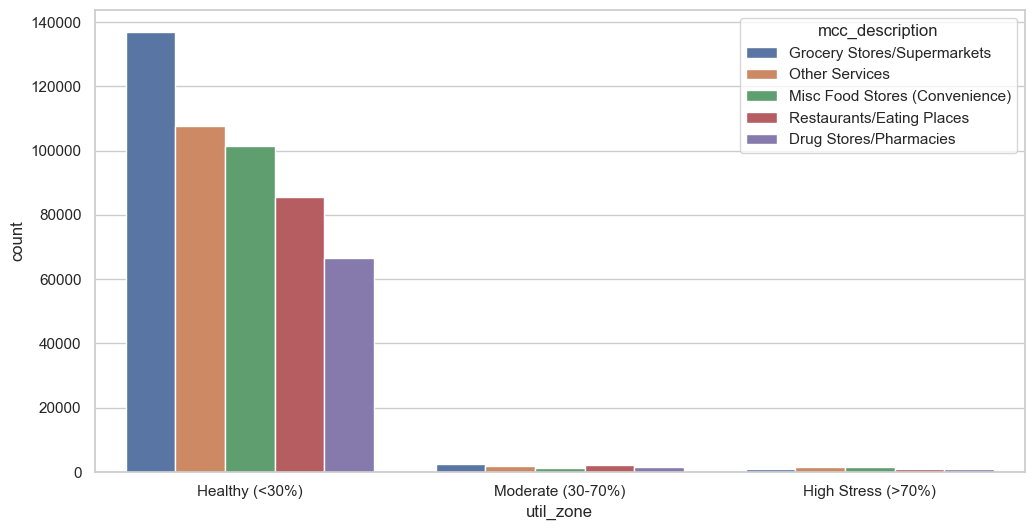

In [44]:
df_final_sample = df_final_sample.reset_index(drop=True)

# 2. Ensure utilization_rate is numeric (stripping % if necessary)
bins = [0, 0.3, 0.7, 1.1] # 1.1 ensures we catch values exactly at 1.0
labels = ['Healthy (<30%)', 'Moderate (30-70%)', 'High Stress (>70%)']

df_final_sample['util_zone'] = pd.cut(df_final_sample['utilization_rate'], bins=bins, labels=labels)

# 4. Plotting
plt.figure(figsize=(12, 6))
top_5_mccs = df_final_sample['mcc_description'].value_counts().head(5).index

sns.countplot(
    data=df_final_sample, 
    x='util_zone', 
    hue='mcc_description', 
    hue_order=top_5_mccs
)

**Healthy users dominate overall activity (expected)**

The Healthy (<30%) zone dwarfs the others across all MCCs.

This means:Most users are financially healthy most of the time. Most transactions naturally occur in this state.

**In Moderate & High Stress zones, behavior shifts toward essentials**

As users become credit-constrained, they reduce discretionary spending first and preserve essentials.




C:\Users\ritik\AppData\Local\Temp\ipykernel_20744\2806182197.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_loyalty.values, y=avg_loyalty.index, palette='crest')


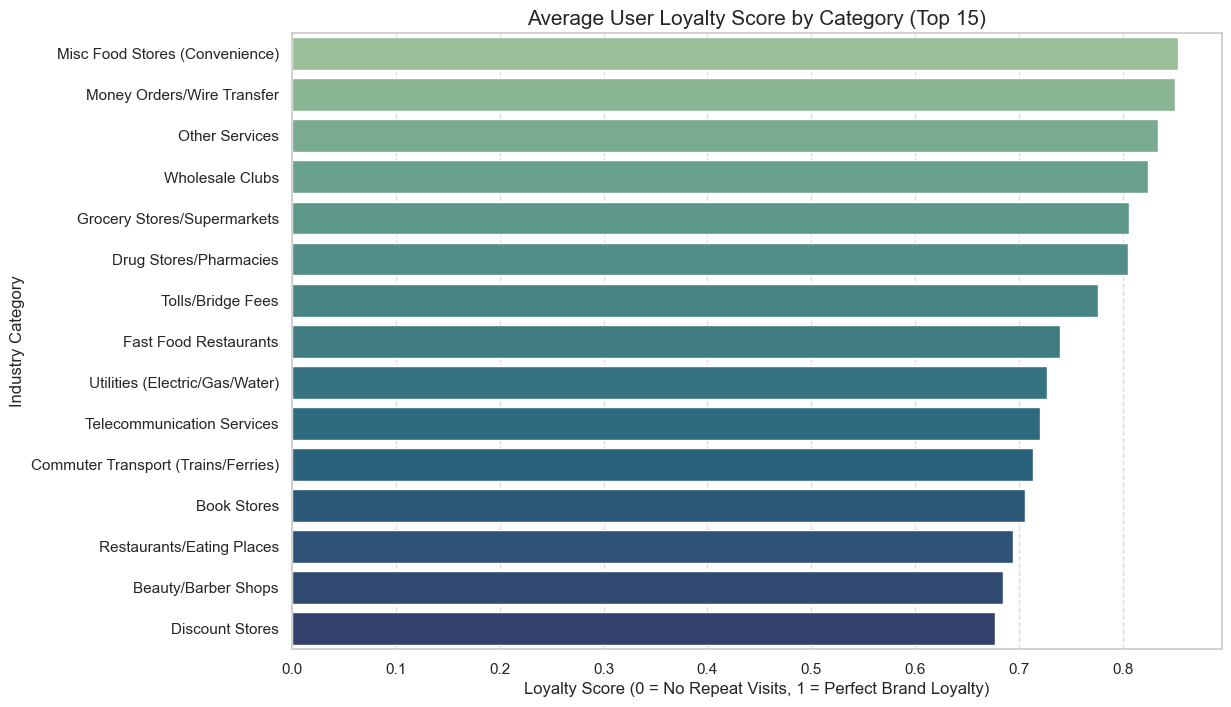

In [46]:

# We look at how many unique merchants they visit vs total visits in that category
mcc_loyalty = df_final_sample.groupby(['user_id', 'mcc_description']).agg(
    merchant_count=('merchant_name', 'nunique'),
    visit_count=('merchant_name', 'count')
).reset_index()

# Formula: Loyalty is higher when merchant_count is low relative to visit_count
mcc_loyalty['category_loyalty'] = 1 - (mcc_loyalty['merchant_count'] / mcc_loyalty['visit_count'])

# 3. Aggregate to find average loyalty per industry for the Top 15 categories
avg_loyalty = mcc_loyalty.groupby('mcc_description')['category_loyalty'].mean().sort_values(ascending=False).head(15)

# 4. Plotting the results
plt.figure(figsize=(12, 8))
sns.barplot(x=avg_loyalty.values, y=avg_loyalty.index, palette='crest')

plt.title('Average User Loyalty Score by Category (Top 15)', fontsize=15)
plt.xlabel('Loyalty Score (0 = No Repeat Visits, 1 = Perfect Brand Loyalty)', fontsize=12)
plt.ylabel('Industry Category', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

"The Category Loyalty analysis identifies the behavioral 'stickiness' of different merchant sectors. By quantifying the ratio of unique merchant visits to total transactions, we can segment the recommendation engine's logic: High-loyalty MCCs utilize 'Retention' algorithms, while low-loyalty MCCs (like Dining and Transportation) trigger 'Discovery' algorithms to maximize user engagement."

**Some categories naturally create loyal behavior (people return to the same merchant), while others encourage exploration.**

For Modelling:

**High loyalty categories:** Recommend the same merchant. Focus on convenience & reminders

**Low loyalty categories:** Recommend new merchants. Emphasize discovery & variety

## Weekday v/s Weekend Spend Analysis

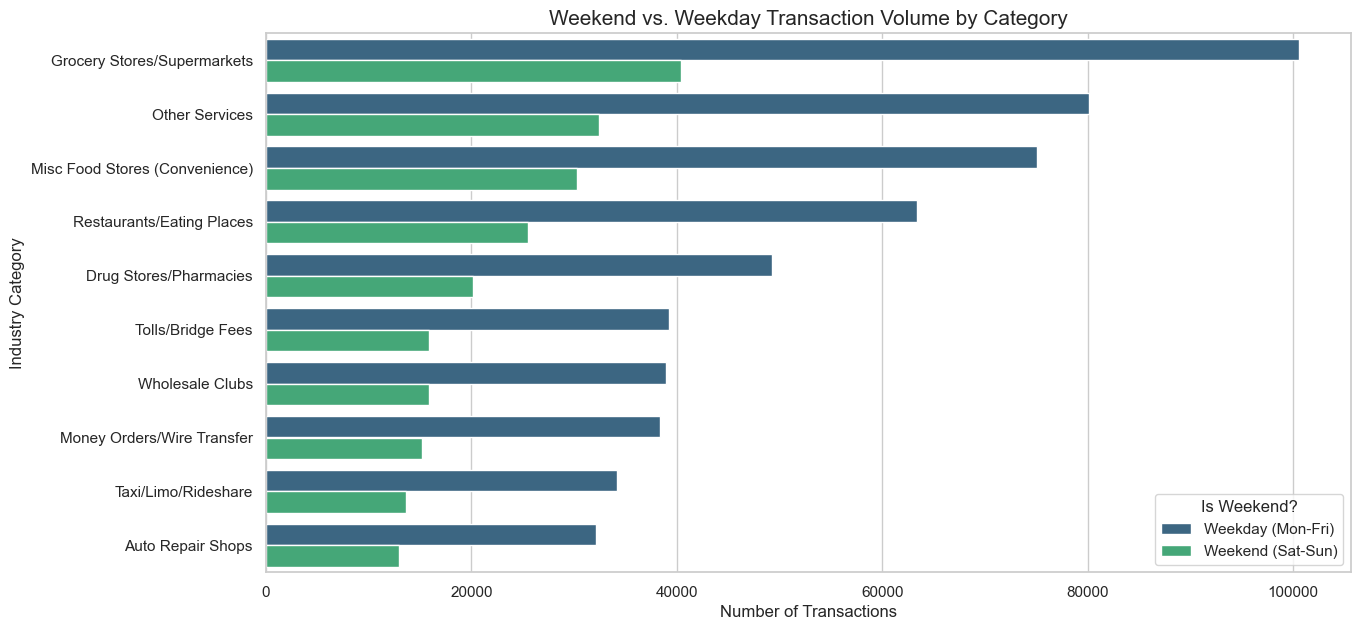

In [48]:
#  Count transactions by MCC and Weekend status
plt.figure(figsize=(14, 7))

# Get top 10 categories to keep the plot readable
top_10_mccs = df_final_sample['mcc_description'].value_counts().head(10).index

#  Create a grouped bar chart
sns.countplot(
    data=df_final_sample, 
    y='mcc_description', 
    hue='is_weekend', 
    order=top_10_mccs,
    palette='viridis'
)

plt.title('Weekend vs. Weekday Transaction Volume by Category', fontsize=15)
plt.xlabel('Number of Transactions', fontsize=12)
plt.ylabel('Industry Category', fontsize=12)
plt.legend(title='Is Weekend?', labels=['Weekday (Mon-Fri)', 'Weekend (Sat-Sun)'])
plt.show()

**Weekday Dominance:** Across every major category, the transaction volume is significantly higher on Weekdays (Mon-Fri) than on Weekends (Sat-Sun).

**Essential "Routine" Categories:** Grocery Stores/Supermarkets and Misc Food Stores (Convenience) show the highest overall activity. This confirms these are "high-frequency" anchors for your model.

**Commuter Patterns:** High weekday volume in Tolls/Bridge Fees, Taxi/Limo/Rideshare, and Auto Repair Shops strongly indicates work-related commuting behavior.

**Model Impact:** We should implement a Temporal Decay or Boost feature. For example, boost the relevance of 'Restaurants' and 'Groceries' during the Weekend flag, while boosting 'Tolls' and 'Professional Services' during the Weekday flag.

**User Segmentation:** We can segment users into 'Commuters' (high weekday toll/auto activity) and 'Socializers' (proportionately higher weekend restaurant activity) to further personalize merchant discovery.

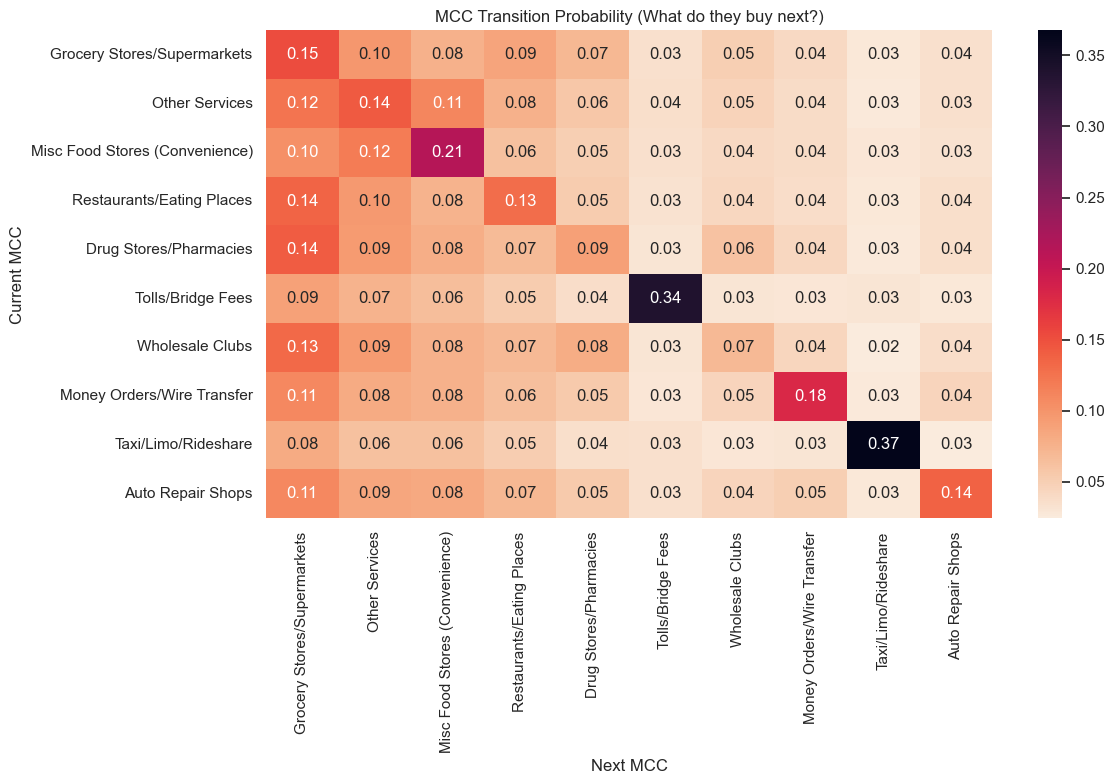

In [50]:
# Sort transactions chronologically per user
df_final_sample = df_final_sample.sort_values(
    ['user_id', 'transaction_timestamp']
)

# Create next MCC per user
df_final_sample['next_mcc'] = (
    df_final_sample
    .groupby('user_id')['mcc_description']
    .shift(-1)
)

# Drop last transaction per user (no next MCC)
transitions = df_final_sample.dropna(subset=['next_mcc'])

# Build transition probability matrix
matrix = pd.crosstab(
    transitions['mcc_description'],
    transitions['next_mcc'],
    normalize='index'
)

# Select top 10 MCCs by transaction volume
top_mccs = (
    transitions['mcc_description']
    .value_counts()
    .head(10)
    .index
)

# Subset matrix to top MCCs only
matrix_top = matrix.loc[top_mccs, top_mccs]

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    matrix_top,
    annot=True,
    fmt=".2f",
    cmap='rocket_r'
)
plt.title("MCC Transition Probability (What do they buy next?)")
plt.xlabel("Next MCC")
plt.ylabel("Current MCC")
plt.tight_layout()
plt.show()
